In [1]:
!pip install --upgrade ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.8 MB/s eta 0:00:00


In [2]:
# Imports
import json, shutil, yaml, warnings, gc
from pathlib import Path
from PIL import Image
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


In [3]:
import os

# Base dataset path (update according to what the print above shows)
base_path = "/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset"

yaml_content = f"""
# YOLO Dataset Configuration File

train: {base_path}/train/images
val: {base_path}/val/images
test: {base_path}/test/images

nc: 2
names: ['small-vehicle', 'large-vehicle']
"""

yaml_path = "/kaggle/working/data_vehicle.yaml"

with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

print("✅ data.yaml updated and saved successfully.")

✅ data.yaml updated and saved successfully.


In [4]:
# Paths
BASE  = Path("/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset")
WORK  = Path("/kaggle/working/")
SPLIT = WORK / "0_yolo_split"
DATA  = WORK/ "data_vehicle.yaml"
SSL_W = WORK/ "byol_backbone_with_hooks_y10.pth"
WORK.mkdir(parents=True, exist_ok=True)

In [5]:
# Two-view dataset  (robust to mixed extensions)
class TwoView(Dataset):
    SUPP = ('*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG')
    def __init__(self, roots, tfm):
        self.files = []
        for r in roots:
            pr = Path(r)
            for pattern in self.SUPP:
                self.files.extend(pr.rglob(pattern))
        if not self.files:
            raise RuntimeError(f"No images found under {roots}")
        self.tfm = tfm
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)

augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(),
])

In [6]:
# NT-Xent loss (FP16-safe)
def nt_xent(z1, z2, tau=0.2):
    B = z1.size(0)
    z1 = z1.float(); z2 = z2.float()
    z = torch.cat([z1, z2], 0)           # 2B × d
    sim = z @ z.T / tau
    idx = torch.arange(2*B, device=z.device)
    sim[idx, idx] = -1e4                 # large negative within fp16 range
    pos = torch.cat([(z1*z2).sum(1)/tau]*2, 0)
    return (-pos + torch.logsumexp(sim, 1)).mean()

In [7]:
# SimCLR pre-training (AMP, batch 16, num_workers = 0)
SSL_EPOCHS, SSL_BATCH = 20, 16

if SSL_W.exists():
    print("✓ SimCLR backbone cached – skipping pre-train")
else:
    print("\n🔄  SimCLR pre-training …")

    backbone = YOLO("yolov10s.yaml").model.model[0].to(device)
    opt     = torch.optim.AdamW(backbone.parameters(), lr=1e-3)
    scaler = torch.amp.GradScaler("cuda")

    ds = TwoView(["/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/train/images", "/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/val/images"], augment)
    dl = DataLoader(ds, batch_size=SSL_BATCH, shuffle=True,
                    num_workers=0, pin_memory=False, drop_last=True)

    for ep in range(SSL_EPOCHS):
        backbone.train(); tot = 0
        for v1, v2 in tqdm(dl, leave=False, desc=f"SSL {ep+1}/{SSL_EPOCHS}"):
            v1, v2 = v1.to(device), v2.to(device)
            with torch.amp.autocast("cuda"):
                f1 = backbone(v1)[-1].flatten(1)
                f2 = backbone(v2)[-1].flatten(1)
                z1 = F.normalize(f1, dim=1)
                z2 = F.normalize(f2, dim=1)
                loss = nt_xent(z1, z2)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad()
            tot += loss.item()
        print(f"Epoch {ep+1}/{SSL_EPOCHS}  loss={tot/len(dl):.4f}")

    torch.save(backbone.state_dict(), SSL_W)
    del backbone, dl, ds; gc.collect(); torch.cuda.empty_cache()
    print("✓ Saved backbone →", SSL_W)


🔄  SimCLR pre-training …


SSL 1/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 1/20  loss=3.2927


SSL 2/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 2/20  loss=2.7537


SSL 3/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 3/20  loss=2.6619


SSL 4/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 4/20  loss=2.6049


SSL 5/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 5/20  loss=2.5882


SSL 6/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 6/20  loss=2.5736


SSL 7/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 7/20  loss=2.5621


SSL 8/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 8/20  loss=2.5630


SSL 9/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 9/20  loss=2.5356


SSL 10/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 10/20  loss=2.5685


SSL 11/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 11/20  loss=2.5714


SSL 12/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 12/20  loss=2.5613


SSL 13/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 13/20  loss=2.5583


SSL 14/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 14/20  loss=2.5291


SSL 15/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 15/20  loss=2.5469


SSL 16/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 16/20  loss=2.5670


SSL 17/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 17/20  loss=2.5647


SSL 18/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 18/20  loss=2.5501


SSL 19/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 19/20  loss=2.5530


SSL 20/20:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch 20/20  loss=2.5260
✓ Saved backbone → /kaggle/working/byol_backbone_with_hooks_y10.pth


In [8]:
# 7. Fine-tune YOLOv8-s detector
print("\n🚀 Fine-tuning YOLOv10-s")
det = YOLO("yolov10s.yaml")
det.model.model[0].load_state_dict(torch.load(SSL_W), strict=False)
det.train(data=str(DATA), epochs=20, imgsz=640, batch=16,
          project=str(WORK), name="simclr_yolov10s", device=0)


🚀 Fine-tuning YOLOv10-s
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data_vehicle.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=simclr_yolov10s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       5420      81053      0.791      0.708      0.774      0.497
         small-vehicle       4592      71035      0.878      0.853      0.913      0.601
         large-vehicle       2394      10018      0.704      0.563      0.636      0.394
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/simclr_yolov10s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7be21f8f9690>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Running prediction on: drone_vsai_q_DJI_09241__1024__1648___824.png

image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/drone_vsai_q_DJI_09241__1024__1648___824.png: 640x640 12 small-vehicles, 15.0ms
Speed: 3.0ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


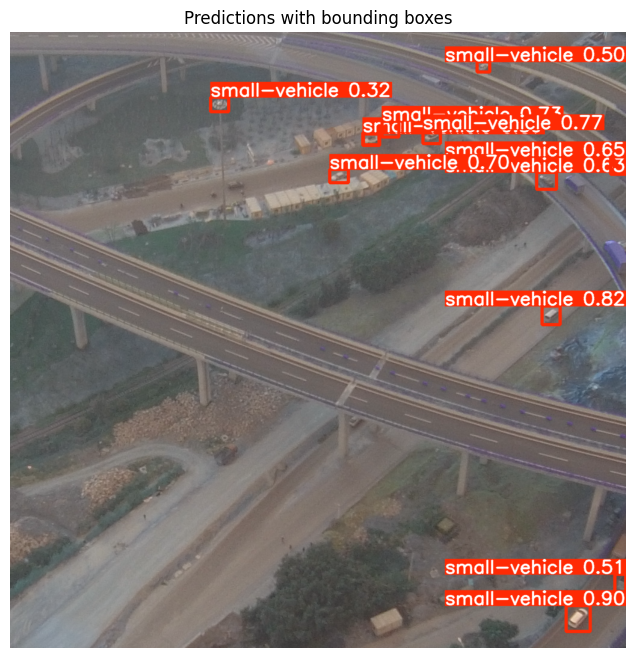

In [9]:
import os
from pathlib import Path
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# Path to the trained weights (adjust if you saved in a different folder/name)
weights_path = Path("/kaggle/working/simclr_yolov10s/weights/best.pt")

# Fallback: if fine‑tuning did not run, fall back to the pre‑trained yolov8s
if not weights_path.exists():
    weights_path = "yolov8s.pt"

# Load the model
model = YOLO(str(weights_path))

# Pick the first image in the test split
test_img_dir = Path("/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images")
img_path = next(test_img_dir.glob("*"))

print(f"Running prediction on: {img_path.name}")
results = model(img_path, imgsz=640, conf=0.25)[0]  # get first (and only) Result

# Get an image with bounding boxes drawn
pred_img = Image.fromarray(results.plot())

# Display
plt.figure(figsize=(8,8))
plt.imshow(pred_img)
plt.axis('off')
plt.title("Predictions with bounding boxes")
plt.show()


Image: /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/dior_02567.jpg

image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/dior_02567.jpg: 640x640 5 large-vehicles, 14.9ms
Speed: 2.6ms preprocess, 14.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


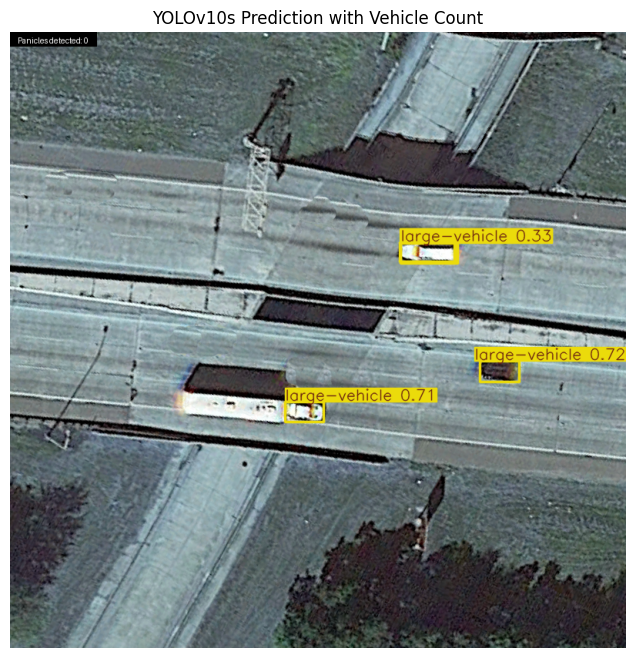

In [10]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO

# -----------------------------------------
# 1. Load the trained model weights
# -----------------------------------------
weights = Path("/kaggle/working/simclr_yolov10s/weights/best.pt")
if not weights.exists():
    # fallback to pretrained small model if fine‑tune weights are missing
    weights = "yolov10s.pt"

model = YOLO(str(weights))

# -----------------------------------------
# 2. Select a sample image from test split
# -----------------------------------------
test_dir = Path("/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images")
img_path = sorted(test_dir.glob("*"))[50]  # take the first image
print("Image:", img_path)

# -----------------------------------------
# 3. Run inference
# -----------------------------------------
res = model(img_path, imgsz=640, conf=0.25)[0]

# Count detections for class 0 (panicle)
panicle_count = int((res.boxes.cls == 0).sum().item())

# -----------------------------------------
# 4. Plot bounding boxes & count
# -----------------------------------------
# Convert Ultralytics' result plot (numpy array) to PIL
plot_img = Image.fromarray(res.plot())
draw = ImageDraw.Draw(plot_img)

# Choose a basic font (PIL built‑in)
try:
    font = ImageFont.truetype("DejaVuSans-Bold.ttf", 32)
except IOError:
    font = ImageFont.load_default()

text = f"Panicles detected: {panicle_count}"
text_size = draw.textbbox((0, 0), text, font=font)
box_height = text_size[3] - text_size[1] + 10

# Draw a filled rectangle for readability
draw.rectangle([(0, 0), (text_size[2] + 20, box_height)], fill=(0, 0, 0, 180))
draw.text((10, 5), text, fill="white", font=font)

# -----------------------------------------
# 5. Display
# -----------------------------------------
plt.figure(figsize=(8, 8))
plt.imshow(plot_img)
plt.axis('off')
plt.title("YOLOv10s Prediction with Vehicle Count")
plt.show()

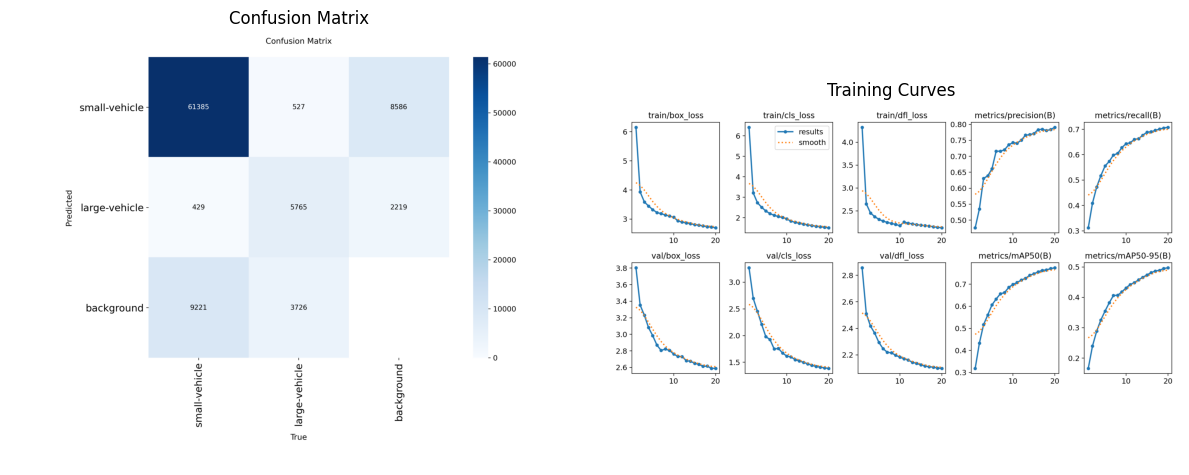

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
15,16,7908.46,2.79077,1.62267,2.17964,0.78343,0.69039,0.75592,0.48143,2.63714,1.44148,2.11636,0.000429,0.000429,0.000429
16,17,8388.85,2.76710,1.58698,2.16806,0.78491,0.69586,0.76282,0.48651,2.61407,1.42284,2.11076,0.000347,0.000347,0.000347
17,18,8868.84,2.73377,1.55920,2.15209,0.78062,0.70060,0.76441,0.48893,2.61602,1.40749,2.10790,0.000264,0.000264,0.000264
18,19,9348.51,2.73091,1.53370,2.14125,0.78391,0.70526,0.77050,0.49499,2.58914,1.39469,2.10032,0.000182,0.000182,0.000182
19,20,9829.32,2.70063,1.50947,2.12953,0.79104,0.70812,0.77426,0.49727,2.58956,1.38617,2.09864,0.000099,0.000099,0.000099


In [11]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

run_dir = Path("/kaggle/working/simclr_yolov10s")

cm_img  = run_dir / "confusion_matrix.png"
res_img = run_dir / "results.png"
csv_file = run_dir / "results.csv"

# ---- show the two images ----
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for a, p, title in zip(ax, [cm_img, res_img],
                       ["Confusion Matrix", "Training Curves"]):
    a.imshow(plt.imread(p))
    a.set_title(title)
    a.axis("off")
plt.tight_layout()
plt.show()

# ---- show the first rows of results.csv ----
df = pd.read_csv(csv_file)
df.tail()


In [12]:
from ultralytics import YOLO
import numpy as np

# Load best trained model
model = YOLO("/kaggle/working/simclr_yolov10s/weights/best.pt")

# Evaluate the model on the validation set
metrics = model.val()

# Helper function to safely extract scalar values
def get_scalar(value):
    if isinstance(value, (np.ndarray, list)):
        return float(np.mean(value))  # take average if array
    return float(value)

# Extract metrics
map50 = get_scalar(metrics.box.map50)
map5095 = get_scalar(metrics.box.map)
precision = get_scalar(metrics.box.p)
recall = get_scalar(metrics.box.r)
f1 = get_scalar(metrics.box.f1)

# Print results
print("\n📊 Model Evaluation Results:")
print(f"Model Name       : {model.model.name if hasattr(model.model, 'name') else 'YOLOv10 Vehicle Model'}")
print(f"mAP@0.5          : {map50:.4f}")
print(f"mAP@0.5:0.95     : {map5095:.4f}")
print(f"Precision        : {precision:.4f}")
print(f"Recall           : {recall:.4f}")
print(f"F1-Score         : {f1:.4f}")

Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,218,774 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 138.9±45.0 MB/s, size: 59.5 KB)
val: Scanning /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/val/labels... 5420 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5420/5420 505.3it/s 10.7s
WARNING ⚠️ val: Cache directory /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/val is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 339/339 4.4it/s 1:17


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       5420      81053       0.79      0.709      0.774      0.498
         small-vehicle       4592      71035      0.878      0.853      0.913      0.601
         large-vehicle       2394      10018      0.703      0.564      0.636      0.394
Speed: 0.7ms preprocess, 9.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

📊 Model Evaluation Results:
Model Name       : YOLOv10 Vehicle Model
mAP@0.5          : 0.7745
mAP@0.5:0.95     : 0.4977
Precision        : 0.7904
Recall           : 0.7085
F1-Score         : 0.7456


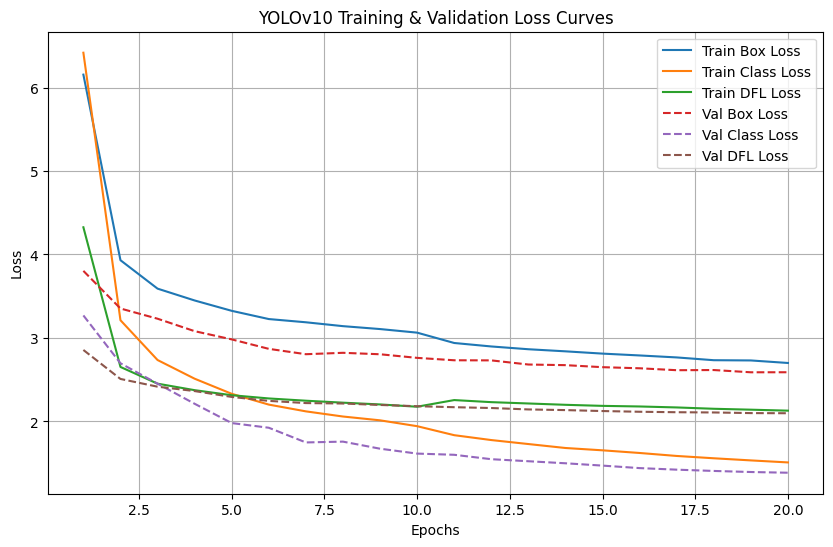

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to results CSV file generated automatically
csv_path = "/kaggle/working/simclr_yolov10s/results.csv"

# Read CSV data
df = pd.read_csv(csv_path)

# Plot losses
plt.figure(figsize=(10,6))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="Train DFL Loss")
plt.plot(df["epoch"], df["val/box_loss"], '--', label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], '--', label="Val Class Loss")
plt.plot(df["epoch"], df["val/dfl_loss"], '--', label="Val DFL Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("YOLOv10 Training & Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()